# RL Open Source Fest 2021 Pre-Screening Exercise

**Applicant:** Wilson Cheung

*Sources*:
[Simulating Content Personalization with Contextual Bandits](https://vowpalwabbit.org/tutorials/cb_simulation.html) and 
[Exploration Algorithms](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Contextual-Bandit-algorithms#changing-action-set-or-featurized-actions)

In the first [Contextual Bandits Reinforcement Learning](https://vowpalwabbit.org/tutorials/contextual_bandits.html) tutorial, we learned about this approach to reinforcement learning with Vowpal Wabbit and contextual bandit algorithms. In this tutorial, we simulate a content personalization scenario with Vowpal Wabbit using contextual bandits to make choices between actions in a given context. The goal is to maximize user engagement as quantified by measuring the expected reward — click-through rate (CTR).

In a contextual bandit setting, a data point has four components:

- Context
- Action
- Probability of choosing the action
- Reward/cost for the chosen action

We need to generate a context in our simulator to get an action/decision for the given context, and to simulate generating a reward. The goal of the simulator is to maximize reward (CTR) — or minimize loss (-CTR).

The **context** is therefore (user, time_of_day):

- We have two website visitors: “Tom” and “Anna.”
- Tom and Anna visit the website in the morning or the afternoon.

We have the option of recommending a variety of articles to Tom and Anna. Therefore, the **actions** are the different choices of articles: “politics”, “sports”, “music”, “food”, “finance”, “health”, or “cheese.”

The **reward** is whether they click on the article or not: “click” or “no click.”

## Getting started
Import the following packages to build this simulation in Python:

In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

## Simulating reward for Vowpal Wabbit
In the real world, we must learn Tom and Anna’s preferences for articles as we observe their interactions. Since this is a simulation, we must define Tom and Anna’s preference profile. 

The reward that we provide to the learner follows this preference profile. We hope to see if the learner can make better and better decisions as we see more samples, which in turn means we are maximizing the reward.

To accomplish this, we need to modify the reward function in a few different ways and see if the contextual bandit learner picks up the changes. Then, we compare the CTR with and without learning.

Vowpal Wabbit optimizes to minimize cost, which is negative of reward. 

Therefore, **we always pass negative of reward as cost to Vowpal Wabbit**.

In [2]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

The reward function below specifies that Tom likes politics in the morning and music in the afternoon. Anna likes sports in the morning and politics in the afternoon. It looks dense, but we are simulating a hypothetical world in the format of the feedback the learner understands — cost.

If the learner recommends an article that aligns with the reward function, we give a positive reward. In our simulation, this is a click:

In [3]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

## Understanding Vowpal Wabbit format
There are steps we need to take to set up our input in a format Vowpal Wabbit understands. 

This function handles converting from our context as a dictionary, list of articles, and the cost if there is one into the text format it understands:

In [4]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

To make sense of this format, we go through an example. In this example, the time of day is morning, and the user is Tom. There are four possible articles. 

In Vowpal Wabbit format, there is one line that starts with shared-the shared context-followed by four lines each corresponding to an article:

In [5]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


## Getting a decision from Vowpal Wabbit
When we call Vowpal Wabbit, the output is a probability mass function (PMF). Vowpal Wabbit provides a list of probabilities over the set of actions because we are incorporating exploration into our strategy. This exploration means that the probability at a given index in the list corresponds to the likelihood of picking that specific action. 

To arrive at a decision/action, we must sample from this list.

For example, given the list **[0.7, 0.1, 0.1, 0.1]**, we would choose the first item with a 70% chance. The command `sample_custom_pmf` takes such a list and gives us the index it chose and what the probability of choosing that index was.

In [6]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

We have all the information we need to choose an action for a specific user and context. Use Vowpal Wabbit to achieve this with the following steps:

1. Convert the context and actions into the text format needed.
2. Pass this example to Vowpal Wabbit and get the PMF output.
3. Sample this PMF to get the article to show.
4. Return the chosen article and the probability of choosing it. 

**Note:** We need the probability when we learn from this example.

In [7]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

## Reinforcement learning simulation
Now that we have done all of the setup work and we know how to interface with Vowpal Wabbit let’s simulate the world of Tom and Anna. The scenario is as follows: Tom and Anna go to a website and are shown an article. Remember that the reward function allows us to define the real-world reaction to the content that Vowpal Wabbit recommends.

We choose between Tom and Anna uniformly at random and choose the time of day they visit the site uniformly at random. Think of this as flipping a coin to choose between Tom and Anna and flipping the coin again to choose the time of day.

In [8]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

## Instantiate learner
We instantiate a contextual bandit learner in Vowpal Wabbit and then simulate Tom and Anna’s website visits num_iterations number of times. With each visit, we do the following:

1.  Decide between Tom and Anna
2.  Decide the time of day
3.  Pass context (i.e., user, time of day) to the learner to get action (i.e., article recommendation, and the probability of choosing action).
4.  Receive reward (i.e., see if the user clicked or not). Remember that cost is just a negative reward.
5.  Format context, action, probability, reward in Vowpal Wabbit format
6.  Learn from the example

**Note:** Vowpal Wabbit reduces a contextual bandit problem to a cost-sensitive multiclass classification problem.

This reduction is the same for every one of our simulations, so we define the process in the run_simulation function. We have to supply the cost function to simulate how the real world works:

In [9]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr

**Note:** `finish_example` is important as it updates statistics and frees used memory.

We want to be able to visualize what is occurring, so we are going to plot the click-through rate over each iteration of the simulation. The CTR is higher if Vowpal Wabbit is showing actions that get rewards. Use this utility function to make showing the plot easier:

In [10]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

## First scenario
First, we use the first reward function `get_cost` and assume that Tom and Anna do not change their preferences over time to see what happens to user engagement as we learn. Then, we see what happens when there is no learning. We use the no learning case as our baseline comparison.

### With learning

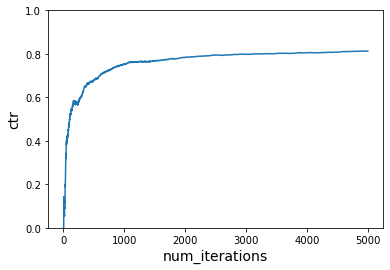

In [11]:
# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

### Interactions
You’ll notice that we include `-q UA` in the arguments we supply to Vowpal Wabbit. This step tells Vowpal Wabbit to create additional features, which are the features in the (U)ser namespace and (A)ction namespaces multiplied together. Doing so allows us to learn the interaction between when specific actions are good at certain times of days and for specific users.

If we didn’t include `-q UA`, the learning would not work. We can see that in the following action:

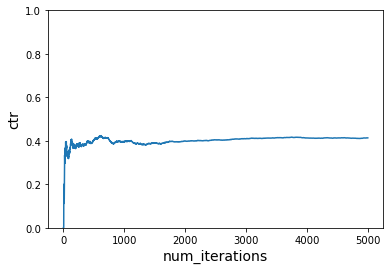

In [12]:
# Instantiate learner in VW but without -q
random.seed(1)
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

### Without learning
Let’s do the same thing again, but with `-q`. This step shows the effect if we don’t learn from what happens. The CTR never improves, and we hover around 0.2.

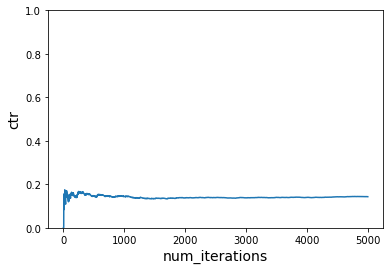

In [13]:
# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

## Second scenario
People’s preferences change over time in the real world. To account for this in the simulation, we incorporate two different cost functions and swap over to the second one halfway through.

The following table represents the new reward function `get_cost_new1`:

| Tom | `get_cost` | `get_cost_new1` |
| --- | --- | --- |
| Morning | Politics | Politics |
| Afternoon | Music | Sports |


| Anna | `get_cost` | `get_cost_new1` |
| --- | --- | --- |
| Morning | Sports | Sports |
| Afternoon | Politics | Sports |

This reward function is still working with the previous learner actions:

In [14]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

To make it easy to show the effect of the cost function changing, we modify the `run_simulation` function. It is a little less readable, but it supports accepting a list of cost functions, and it operates over each cost function in turn.

This change is perfect for our scenario:

In [15]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

### With learning
Now, we switch to the second reward function after a few samples (running the first reward function). Recall that this reward function changes the preferences of web users, but it is still working with the same action space as before. We should see the learner pick up these changes and optimize the new preferences.

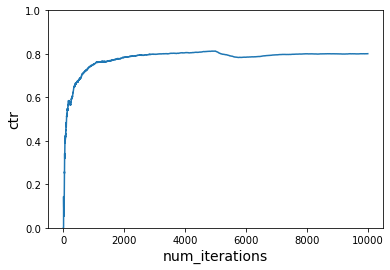

In [16]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

**Note:** The initial spike in CTR depends on the rewards received for the first few examples. When you run on your own, you may see something different initially because our simulator is designed to have randomness.

### Without learning
We repeat this step without learning to demonstrate the effect:

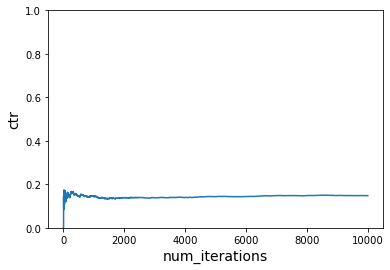

In [17]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

## Python / Data Science Exercise

The goals of this exercise is to modify the second scenario in the following ways:

- Add multiple changes to the reward distribution over time
- Introduce varying noise in the reward distribution

We additionally run this new simulator against different exploration algorithms and perform a comparative analysis through our visualizations.

## Third scenerio

In the tutorial provided above, the definition of cost (shown below) makes the assumption that a user have a strict binary definition of their article preferences. We can think of this cost definition as the negative probability of a user liking a given article.  

    # VW tries to minimize loss/cost, therefore we will pass cost as -reward
    USER_LIKED_ARTICLE = -1.0
    USER_DISLIKED_ARTICLE = 0.0
    
Realistically, users can partially like or dislike articles based on their past exposure to previous articles. Over time, users should develop stronger preferences as they acquire more experience reading articles. We attempt to model this as follows:

### Time-dependent reward distribution

We begin by extending the current definition of cost by re-defining a time-sensitive reward function that adopts the similar notion of discounted rewards in reinforcement learning.

Specifically, let $\gamma \; (0 \leq \gamma \leq 1)$ represent the discount factor, let $X$ represent the binary random variable representing the event that a user likes or dislikes the article (respectively $X = 1$ and $X = 0$), and let $T$ represent the random variable representing the event occurring at given time step $t$. Then, for all time steps $t \geq 0$ and $k \in \{0, 1\}$, define the cost function as follows:

$$P ( X = k \cap  T = t ) = \frac{1}{2} + (2k - 1) (1 - \gamma^t) \frac{1}{2}.$$

Intuitively, what this represents is that during initialization of the numerical experiment, the user is assumed to have an unbiased preference for any given article. This realistically makes sense because the user have no other articles to compare against in defining their preferences in the first iteration.

As the user acquire more experience being exposed to more articles (equivalently as $t$ increases), these preferences become more refined with respect to time (rate controlled by hyperparameter $\gamma$). For sufficiently large $t$, the cost constants converge to the preference metrics used in our previous numerical experiments.

Therefore, we define the `parameterized_cost_constants` function as follows:

In [18]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
def parameterized_cost_constants(gamma, timestep):
    return tuple(-0.5 - 0.5*(2*like - 1)*(1 - gamma**(timestep)) for like in [1, 0])

For $t = 0$, we define both cost constants to be $-\frac{1}{2}$ to reflect no bias due to insufficient sample size of exposed articles for each user.

In [19]:
gamma, timestep = 0.5, 0
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-0.5, -0.5)

Note that when $\gamma = 0$, the problem degenerates to our previous experimental results.

In [20]:
gamma, timestep = 0, 10
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-1.0, 0.0)

For $\gamma = 1$, the problem unrealistically captures the experiment when the cost constants reflect no bias for all time steps $t$.

In [21]:
gamma, timestep = 1, 10
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-0.5, -0.5)

### Adding noise

In addition to time-sensitivity, noise factors in the randomness of the user's preferences. This is more reflective of reality due to varying conditions that are uncaptured in the model proposed so far. 

To successfully add noise to our random variables under constrained interval $[0, 1]$, we first need to define the `logit()` and `inv_logit()` transformation functions to properly add noise to our probabilities.


In [22]:
import numpy as np

## ep parameter for numerical stability
def logit(prob, ep = 1e-3):
    return np.log((prob + ep) / (1 - prob + ep))

def inv_logit(value):
    return (1 + np.exp(-value))**(-1)

Specifically, let $p(k, t) := P ( X = k \cap  T = t ).$ Then, we define the results of the logit transformation as follows:

$$q(k, t) := \log \left( \frac{p(k, t)}{ 1- p(k, t)} \right)$$

Standardly, noise is assumed to be Gaussian distributed with mean $0$. We ensure that variance is time step sensitive so that as $t \rightarrow \infty$, $\epsilon_t \rightarrow 0$, and our unbiased probabilities converge to the desired $\frac{1}{2}$. We can add $\epsilon_t \sim N( 0, \frac{1}{t+1})$ simply by defining $\tilde{q}(k, t)$ as follows:

$$\tilde{q}(k, t) := q(k, t) + \epsilon_t$$

Transforming $\tilde{q}(k, t)$ back into probability space yields the desired noisy probabilities $\tilde{p}(k, t)$:

$$\tilde{p}(k, t) := \frac{1}{1+\text{exp}(-\tilde{q}(k, t))}$$

Remodifying the `parameterized_cost_constants` function to incorporate noise, we get the following:

In [23]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
def parameterized_cost_constants(gamma, timestep, noisy = True):
    epsilon = random.gauss(0, (timestep+1)**-1) if noisy else 0
    prob = lambda like: 0.5 + 0.5*(2*like - 1)*(1 - gamma**(timestep))
    return tuple(-1*inv_logit(logit(prob(like)) + (2*like - 1)*epsilon) for like in [1, 0])

Based on our previous evaluations of `USER_LIKED_ARTICLE` and `USER_DISLIKED_ARTICLE`, we see that noise implementation is successful when toggled on. We may observe cases where `USER_LIKED_ARTICLE` is unintuitively greater than `USER_DISLIKED_ARTICLE`, but this is aimed to capture irrationality of the user due to external conditions uncontrolled in this experiment. Due to the decreasing variance, the user's irrationality will become less significant as $t \rightarrow \infty$ due to discount factor $0 < \gamma < 1$.

In [24]:
gamma, timestep = 0.5, 0
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-0.30785780455785783, -0.6921421954421422)

In [25]:
gamma, timestep = 0, 10
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-0.9988217647398449, -0.0011782352601552165)

In [26]:
gamma, timestep = 1, 10
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep)
USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE

(-0.5196316756802798, -0.48036832431972026)

### Generalizing cost functions and numerical simulations

Now that we have successfully defined `parameterized_cost_constants`, we generalize both `get_cost_new1` and `get_cost` functions to incorporate time dependency and noise in our reward distribution. Respectively, we name the functions `get_noisy_cost_new1` and `get_noisy_cost`. 

In [27]:
def get_noisy_cost(context, action, gamma, timestep, noisy = True):
    USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep, noisy)
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

def get_noisy_cost_new1(context, action, gamma, timestep, noisy = True):
    USER_LIKED_ARTICLE, USER_DISLIKED_ARTICLE = parameterized_cost_constants(gamma, timestep, noisy)
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

Note that both functions will respectively require hyperparameters $\gamma_{\text{new1}}$ and $\gamma_{\text{cost}}$. We construct a new input parameter, `gammas`, defined to be a dictionary mapping the cost functions to its corresponding hyperparameter. We create the `run_simulation_multiple_noisy_cost_functions` function so that `gammas` is now accepted as input for our simulations.

In [28]:
def run_simulation_multiple_noisy_cost_functions(vw, num_iterations, users, times_of_day, actions, gammas, noisy = True, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for noisy_cost_function, gamma in gammas.items():
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = noisy_cost_function(context, action, gamma, i, noisy)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

### Validation of previous numerical results

To confirm that our generalization is successful, we attempt to reproduce our previous results by specifically choosing hyperparameters that degenerate the problem into Scenerio Two. Specifically, we need to set $\gamma_{\text{new1}} = 0$ and $\gamma_{\text{cost}} = 0$, and pass `noisy = False` in our new function to accomplish this.

### With learning

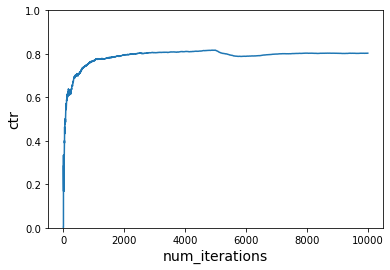

In [29]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

gammas = {
    get_noisy_cost: 0,
    get_noisy_cost_new1: 0 
}

num_iterations_per_cost_func = 5000
total_iterations = num_iterations_per_cost_func * len(gammas)

ctr = run_simulation_multiple_noisy_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, gammas, noisy=False)

plot_ctr(total_iterations, ctr)

### Without learning

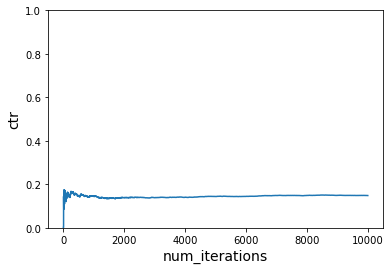

In [30]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
random.seed(1)
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

gammas = {
    get_noisy_cost: 0,
    get_noisy_cost_new1: 0 
}

num_iterations_per_cost_func = 5000
total_iterations = num_iterations_per_cost_func * len(gammas)

ctr = run_simulation_multiple_noisy_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, gammas, noisy=False, do_learn=False)
plot_ctr(total_iterations, ctr)

Based on the above results, we were successful in replicating Scenerio Two.

## Epsilon-greedy numerical experiments

In this section, we will run our generalized simulators across different exploration algorithms to study the overall changes of model performance. We begin by studying the effects of tuning the discount rate $\gamma$ to see how learning is changed under the default epsilon-greedy learning strategy. Define `epsilon_greedy` as follows:

In [31]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
def epsilon_greedy(gamma, epsilon = 0.2, noisy = False, do_learn = True):
    random.seed(1)
    vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon {}".format(epsilon))

    gammas = {
        get_noisy_cost: gamma,
        get_noisy_cost_new1: gamma
    }

    num_iterations_per_cost_func = 5000
    total_iterations = num_iterations_per_cost_func * len(gammas)

    ctr = run_simulation_multiple_noisy_cost_functions(vw,
        num_iterations_per_cost_func, users, times_of_day, actions, gammas, noisy=noisy, do_learn=do_learn)

    plot_ctr(total_iterations, ctr)

For the following plots, we color code the curves as follows:
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0 \rightarrow \text{blue}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.9 \rightarrow \text{orange}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.99 \rightarrow \text{green}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.999 \rightarrow \text{red}$$

### Tuning discount factor $\gamma$ without noise using epsilon-greedy ($\epsilon$ = 0.2)

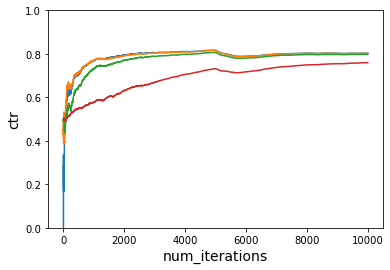

In [32]:
for gamma in [0, 0.9, 0.99, 0.999]:
    epsilon_greedy(gamma)

### Tuning discount factor $\gamma$ with noise using epsilon-greedy ($\epsilon$ = 0.2)

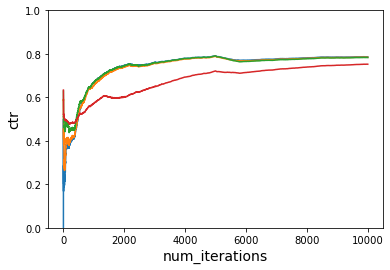

In [33]:
for gamma in [0, 0.9, 0.99, 0.999]:
    epsilon_greedy(gamma, noisy = True)

The two plots above show that the first one thousand iterations are highly sensitive to noise, but as $t \rightarrow \infty$, the values eventually converge to approximately 0.8. We additionally observe that as $\gamma \rightarrow 1$, the parameterized CTR curve converges to the horizontal plot defined by $CTR = 0.5$ (the expected result for $\gamma = 1$).

From the plots above, we see that $\gamma = 0.9$ performs the best. Using this hyperparameter choice, we shift focus to tune $\epsilon$ for epsilon-greedy. The new color mappings are now defined as follows:

$$\epsilon = 0 \rightarrow \text{blue}$$
$$\epsilon = 0.05 \rightarrow \text{orange}$$
$$\epsilon = 0.1 \rightarrow \text{green}$$
$$\epsilon = 0.15 \rightarrow \text{red}$$

### Tuning epsilon without noise using discounted epsilon-greedy ($\gamma$ = 0.9)

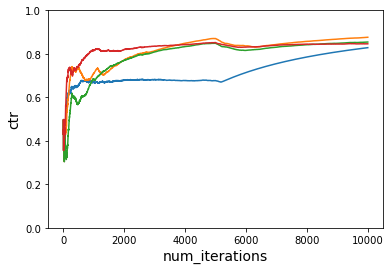

In [34]:
gamma = 0.9
for epsilon in np.arange(0, 0.2, 0.05):
    epsilon_greedy(gamma, epsilon)

### Tuning epsilon with noise using discounted epsilon-greedy ($\gamma$ = 0.9)

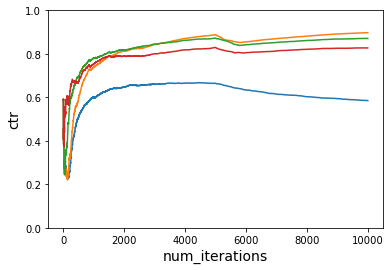

In [35]:
gamma = 0.9
for epsilon in np.arange(0, 0.2, 0.05):
    epsilon_greedy(gamma, epsilon, noisy = True)

We observe that for all choices of $\gamma$ with or without noise, epsilon-greedy method performs best at $\epsilon = 0.05$. Equivalently, this method takes the current predictions gained from the trained policy with probability 0.95 and randomly selects an action with probability 0.05. If $\epsilon$ is too high, the model is more likely to randomly select an action without any policy. If $\epsilon$ is too low, the resulting model becomes too conservative to learn new information via random sampling.

## Epsilon-first numerical experiments

The next exploration algorithm we will study is the epsilon-first algorithm. This algorithm accepts the parameter `tau` and uses the first `tau` examples to learn a starting policy and then uses the policy to further make recommendations for latter iterations.

In [36]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
def epsilon_first(gamma, tau = 2, noisy = False, do_learn = True):
    random.seed(1)
    vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first {}".format(tau))

    gammas = {
        get_noisy_cost: gamma,
        get_noisy_cost_new1: gamma
    }

    num_iterations_per_cost_func = 5000
    total_iterations = num_iterations_per_cost_func * len(gammas)

    ctr = run_simulation_multiple_noisy_cost_functions(vw,
        num_iterations_per_cost_func, users, times_of_day, actions, gammas, noisy=noisy, do_learn=do_learn)

    plot_ctr(total_iterations, ctr)

For the following plots, we color code the curves as follows:
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0 \rightarrow \text{blue}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.9 \rightarrow \text{orange}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.99 \rightarrow \text{green}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.999 \rightarrow \text{red}$$

### Tuning discount factor $\gamma$ without noise using epsilon-first ($\tau$ = 2)

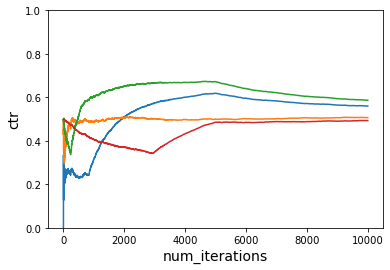

In [37]:
for gamma in [0, 0.9, 0.99, 0.999]:
    epsilon_first(gamma)

### Tuning discount factor $\gamma$ with noise using epsilon-first ($\tau$ = 2)

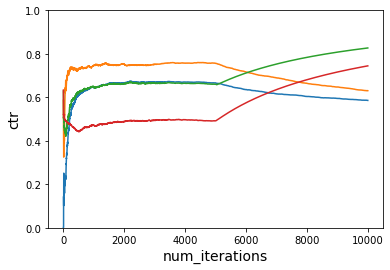

In [38]:
for gamma in [0, 0.9, 0.99, 0.999]:
    epsilon_first(gamma, noisy = True)

For epsilon-first, we observe that the optimal discount factor is $\gamma = 0.99$. Tuning $\tau$ using this discount factor under the following legend:

$$\tau = 2 \rightarrow \text{blue}$$
$$\tau = 20 \rightarrow \text{orange}$$
$$\tau = 200 \rightarrow \text{green}$$
$$\tau = 2000 \rightarrow \text{red}$$

we get the following plots:

### Tuning tau without noise using epsilon-first ($\gamma$ = 0.99)

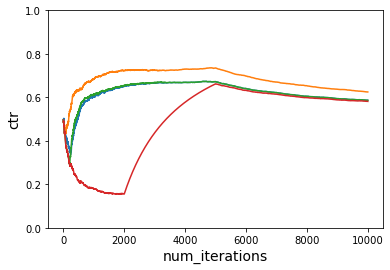

In [39]:
gamma = 0.99
for tau in [2, 20, 200, 2000]:
    epsilon_first(gamma, tau)

### Tuning tau with noise using epsilon-first ($\gamma$ = 0.99)

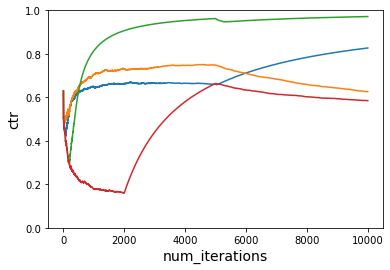

In [40]:
gamma = 0.99
for tau in [2, 20, 200, 2000]:
    epsilon_first(gamma, tau, noisy = True)

Especially for noisy rewards, $\tau = 200$ is the optimal hyperparameter choice for epsilon-first using discounted factor $\gamma = 0.99$.

## Bagging-explorer numerical experiments

The next exploration algorithm we will study is the bagging-explorer algorithm. This algorithm accepts `bag`, a parameter defining the number of policies to train. It constructs an ensemble model and make recommendations based on this model.



In [41]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
def bagging_explorer(gamma, bag = 5, noisy = False, do_learn = True):
    random.seed(1)
    vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag {}".format(bag))

    gammas = {
        get_noisy_cost: gamma,
        get_noisy_cost_new1: gamma
    }

    num_iterations_per_cost_func = 5000
    total_iterations = num_iterations_per_cost_func * len(gammas)

    ctr = run_simulation_multiple_noisy_cost_functions(vw,
        num_iterations_per_cost_func, users, times_of_day, actions, gammas, noisy=noisy, do_learn=do_learn)

    plot_ctr(total_iterations, ctr)

For the following plots, we color code the curves as follows:
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0 \rightarrow \text{blue}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.9 \rightarrow \text{orange}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.99 \rightarrow \text{green}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.999 \rightarrow \text{red}$$

### Tuning discount factor $\gamma$ without noise using bagging-explorer ($n$ = 5)

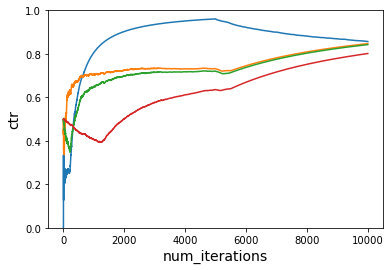

In [42]:
for gamma in [0, 0.9, 0.99, 0.999]:
    bagging_explorer(gamma)

### Tuning discount factor $\gamma$ with noise using bagging-explorer ($n$ = 5)

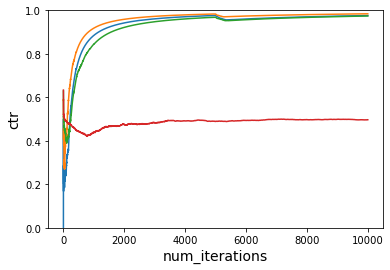

In [43]:
for gamma in [0, 0.9, 0.99, 0.999]:
    bagging_explorer(gamma, noisy = True)

Especially for noisy rewards, bagging explorer algorithm performs best for $\gamma = 0.9$. Ensemble methods typically outperform for generically noisy datasets. Tuning $n$ using this discount factor under the following legend:

$$n = 2 \rightarrow \text{blue}$$
$$n = 3 \rightarrow \text{orange}$$
$$n = 4 \rightarrow \text{green}$$
$$n = 5 \rightarrow \text{red}$$

we get the following plots:

### Tuning $n$ without noise using bagging-explorer ($\gamma$ = 0.9)

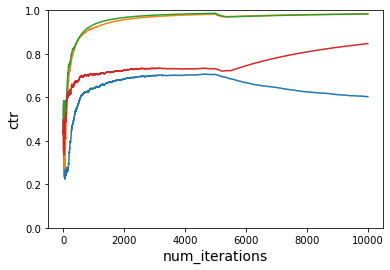

In [44]:
gamma = 0.9
for n in [2, 3, 4, 5]:
    bagging_explorer(gamma, n)

### Tuning $n$ with noise using bagging-explorer ($\gamma$ = 0.9)

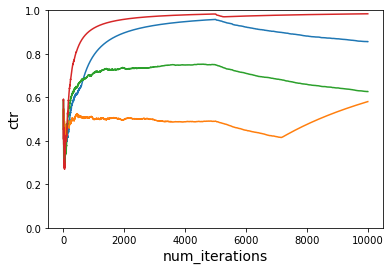

In [45]:
gamma = 0.9
for n in [2, 3, 4, 5]:
    bagging_explorer(gamma, n, noisy = True)

From our experiments, we still observe that $n = 5$ is the optimal hyperparameter choice for bagging explorer algorithm using discounted factor $\gamma = 0.9$.

## Softmax-explorer numerical experiments

The next exploration algorithm we will study is the softmax-explorer algorithm.


In [46]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
def softmax_explorer(gamma, lamb = 10, noisy = False, do_learn = True):
    random.seed(1)
    vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda {}".format(lamb))

    gammas = {
        get_noisy_cost: gamma,
        get_noisy_cost_new1: gamma
    }

    num_iterations_per_cost_func = 5000
    total_iterations = num_iterations_per_cost_func * len(gammas)

    ctr = run_simulation_multiple_noisy_cost_functions(vw,
        num_iterations_per_cost_func, users, times_of_day, actions, gammas, noisy=noisy, do_learn=do_learn)

    plot_ctr(total_iterations, ctr)

For the following plots, we color code the curves as follows:
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0 \rightarrow \text{blue}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.9 \rightarrow \text{orange}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.99 \rightarrow \text{green}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.999 \rightarrow \text{red}$$

### Tuning discount factor $\gamma$ without noise using softmax-explorer ($\lambda$ = 10)

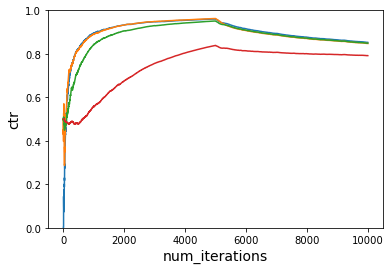

In [47]:
for gamma in [0, 0.9, 0.99, 0.999]:
    softmax_explorer(gamma)

### Tuning discount factor $\gamma$ with noise using softmax-explorer ($\lambda$ = 10)

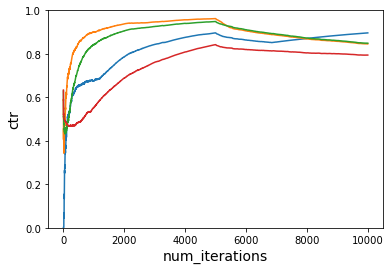

In [48]:
for gamma in [0, 0.9, 0.99, 0.999]:
    softmax_explorer(gamma, noisy = True)

Especially for noisy rewards, softmax explorer algorithm performs best for $\gamma = 0$. Tuning $\lambda$ using this discount factor under the following legend:

$$\lambda = 5 \rightarrow \text{blue}$$
$$\lambda = 10 \rightarrow \text{orange}$$
$$\lambda = 25 \rightarrow \text{green}$$
$$\lambda = 50 \rightarrow \text{red}$$

we get the following plots:

### Tuning $\lambda$ without noise using softmax-explorer ($\gamma$ = 0)

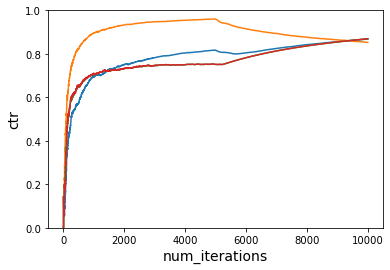

In [49]:
gamma = 0
for lamb in [5, 10, 25, 50]:
    softmax_explorer(gamma, lamb)

### Tuning $\lambda$ with noise using softmax-explorer ($\gamma$ = 0)

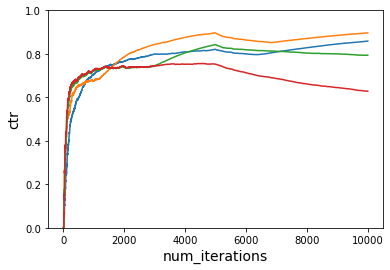

In [50]:
gamma = 0
for lamb in [5, 10, 25, 50]:
    softmax_explorer(gamma, lamb, noisy = True)

From our experiments, we observe that $\lambda = 10$ is the optimal hyperparameter choice for softmax explorer algorithm using discounted factor $\gamma = 0$.

## RND-explorer numerical experiments

The last exploration algorithm we will study is the RND-explorer algorithm.

In [51]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
def rnd_explorer(gamma, epsilon = 0.025, noisy = False, do_learn = True):
    random.seed(1)
    vw = pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon {}".format(epsilon))

    gammas = {
        get_noisy_cost: gamma,
        get_noisy_cost_new1: gamma
    }

    num_iterations_per_cost_func = 5000
    total_iterations = num_iterations_per_cost_func * len(gammas)

    ctr = run_simulation_multiple_noisy_cost_functions(vw,
        num_iterations_per_cost_func, users, times_of_day, actions, gammas, noisy=noisy, do_learn=do_learn)

    plot_ctr(total_iterations, ctr)

For the following plots, we color code the curves as follows:
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0 \rightarrow \text{blue}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.9 \rightarrow \text{orange}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.99 \rightarrow \text{green}$$
$$\gamma_{\text{new1}} = \gamma_{\text{cost}} = 0.999 \rightarrow \text{red}$$

### Tuning discount factor $\gamma$ without noise using RND-explorer ($\epsilon$ = 0.025)

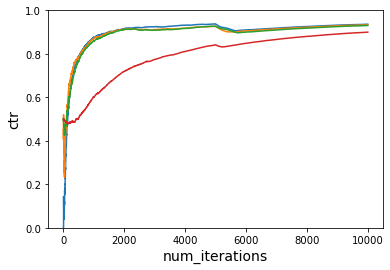

In [52]:
for gamma in [0, 0.9, 0.99, 0.999]:
    rnd_explorer(gamma)

### Tuning discount factor $\gamma$ with noise using RND-explorer ($\epsilon$ = 0.025)

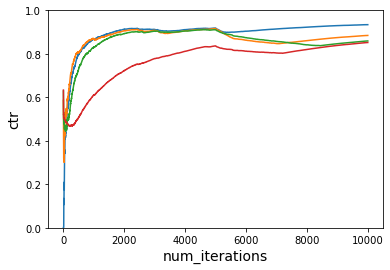

In [53]:
for gamma in [0, 0.9, 0.99, 0.999]:
    rnd_explorer(gamma, noisy = True)

RND explorer algorithm performs best for $\gamma = 0$. Tuning $\epsilon$ using this discount factor under the following legend:

$$\epsilon = 0.01 \rightarrow \text{blue}$$
$$\epsilon = 0.025 \rightarrow \text{orange}$$
$$\epsilon = 0.05 \rightarrow \text{green}$$
$$\epsilon = 0.1 \rightarrow \text{red}$$

we get the following plots:

### Tuning $\epsilon$ without noise using RND-explorer ($\gamma$ = 0)

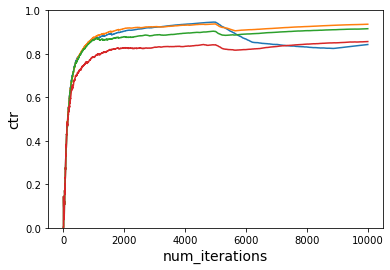

In [54]:
gamma = 0
for epsilon in [0.01, 0.025, 0.05, 0.1]:
    rnd_explorer(gamma, epsilon)

### Tuning $\epsilon$ with noise using RND-explorer ($\gamma$ = 0)

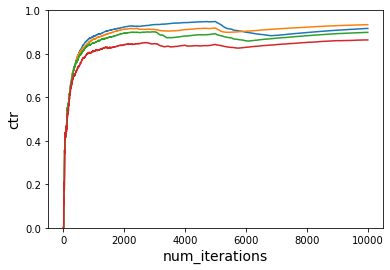

In [55]:
gamma = 0
for epsilon in [0.01, 0.025, 0.05, 0.1]:
    rnd_explorer(gamma, epsilon, noisy = True)

From our experiments, we observe that $\epsilon = 0.025$ is the optimal hyperparameter choice for RND-explorer algorithm using discounted factor $\gamma = 0$.

## Final Results of Simulations

Shown below are the final results of the numerical experiments implemented in this writeup:

| Explorer (with optimal hyperparameters) | Without noise | With noise |
| --- | --- | --- |
| Epsilon-greedy ($\epsilon = 0.05$; $\gamma = 0.9$) | 0.8756527017362791 | 0.8966572165557274 |
| Epsilon-first ($\tau = 200$; $\gamma = 0.99$) | 0.5857262991699186 | 0.9708593726235606 |
| Bagging ($n = 5$; $\gamma = 0.9$) | 0.8464044215521439 | **0.9835779405818937** |
| Softmax ($\lambda = 10$; $\gamma = 0$) | 0.8519960079839378 | 0.8957087119245645 |
| RND ($\epsilon = 0.025$; $\gamma = 0$) | **0.9356287425148428**| 0.9335330105012161 |

### Findings:

- The best performing model is the bagging-exploration algorithm for noisy rewards. This is expected due to how consistently well ensemble methods generically capture the important features of noisy rewards.


- The RND algorithm is the most noise-invariant exploration model. It's possible that noise doesn't play much of a role in the success of this exploration algorithm due to its reliance on full randomization during initialization.


- For most exploration algorithms studied in this writeup, it seems that its overall performance using noisy rewards distribution is better than its less noisy counterpart.

## Conclusion

In this write-up, we were successful in generalizing Scenerio Two to account for time-sensitivity in our rewards distribution using discounting in reinforcement learning. We were also successful in adding time-sensitive Gaussian noise to our model to reflect irrationality of user behavior. Using these generalized exploration models, we performed a number of hyperparameter tuning exercises across the entire Vowpal Wabbit's suite of contextual bandits algorithms and performed a brief analysis detailing our findings after successful tuning.

## Acknowledgements

I would like to thank Microsoft Research NYC for providing me the opportunity to possibly contribute to Vowpal Wabbit's open-source development this summer and further developing my interest and enriching my experiences in reinforcement learning.